<a href="https://colab.research.google.com/github/SnitikaDash/Data-Science-Projects/blob/main/Project_LoanApprovalPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<ipython-input-7-80946aa5a6f4>:20: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)  # Forward fill for simplicity


Accuracy: 1.00
Cross-Validation Accuracy: 0.99


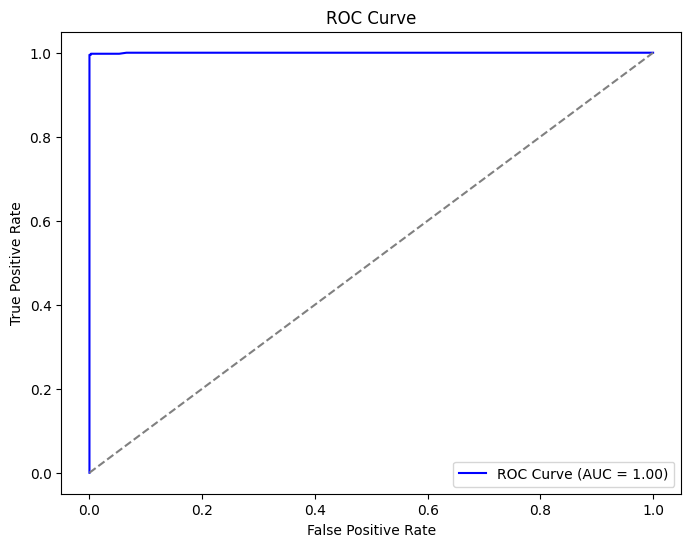

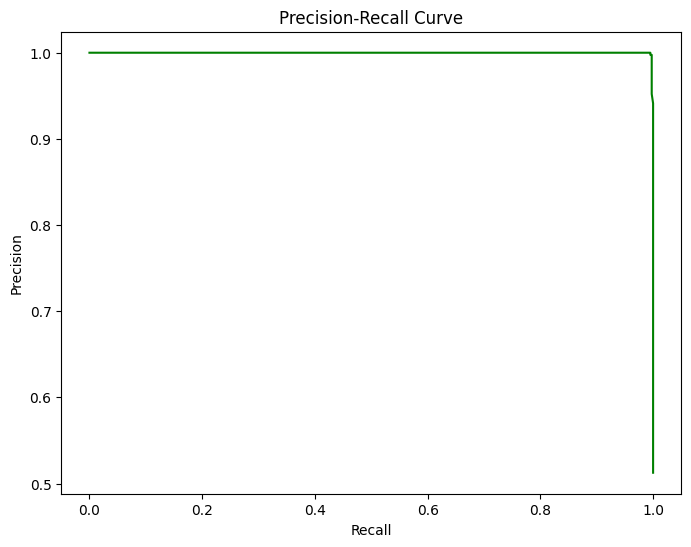

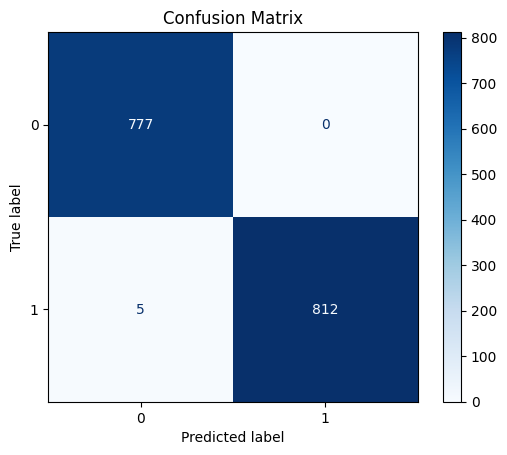

<ipython-input-7-80946aa5a6f4>:124: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importances, y=selected_features, palette='viridis')


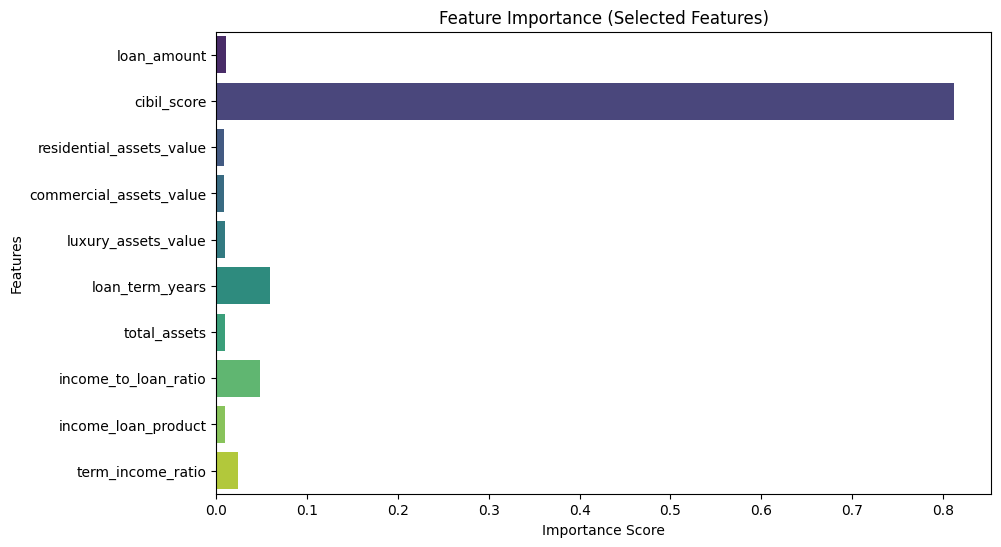

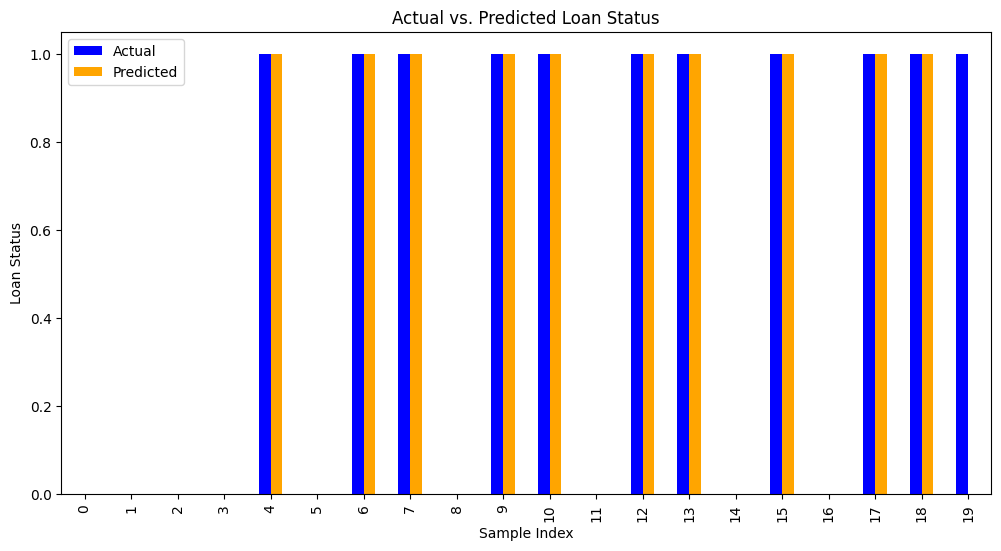

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve, precision_recall_curve
from sklearn.feature_selection import RFE
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV

# Load the dataset
data = pd.read_csv('loan_approval_dataset.csv')

# Clean column names by stripping extra spaces
data.columns = data.columns.str.strip()

# Handling missing values (if any)
data.fillna(method='ffill', inplace=True)  # Forward fill for simplicity

# Encoding categorical variables
encoder = LabelEncoder()
data['education'] = encoder.fit_transform(data['education'])  # Graduate=1, Not Graduate=0
data['self_employed'] = encoder.fit_transform(data['self_employed'])  # Yes=1, No=0
data['loan_status'] = encoder.fit_transform(data['loan_status'])  # Approved=1, Rejected=0

# Feature engineering
# Convert loan_term from months to years
data['loan_term_years'] = data['loan_term'] / 12

# Create a total assets column
data['total_assets'] = (
    data['residential_assets_value'] +
    data['commercial_assets_value'] +
    data['luxury_assets_value'] +
    data['bank_asset_value']
)

# Create an income-to-loan ratio feature
data['income_to_loan_ratio'] = data['income_annum'] / (data['loan_amount'] + 1e-6)  # Avoid division by zero

# Create interaction terms
data['income_loan_product'] = data['income_annum'] * data['loan_amount']
data['term_income_ratio'] = data['loan_term_years'] / (data['income_annum'] + 1e-6)

# Define features and target
X = data.drop(['loan_id', 'loan_status', 'loan_term'], axis=1)
y = data['loan_status']

# Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Scale numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_resampled)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_resampled, test_size=0.3, random_state=42)

# Hyperparameter tuning using GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, n_jobs=-1, scoring='accuracy')
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

# Recursive Feature Elimination (RFE)
rfe = RFE(estimator=RandomForestClassifier(random_state=42), n_features_to_select=10)
rfe.fit(X_train, y_train)
selected_features = X.columns[rfe.support_]

# Train the final model on selected features
X_train_rfe = rfe.transform(X_train)
X_test_rfe = rfe.transform(X_test)
final_model = RandomForestClassifier(random_state=42)
final_model.fit(X_train_rfe, y_train)

# Predictions and evaluation
y_pred = final_model.predict(X_test_rfe)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Cross-validation scores
cv_scores = cross_val_score(final_model, X_train_rfe, y_train, cv=5, scoring='accuracy')
print(f'Cross-Validation Accuracy: {np.mean(cv_scores):.2f}')

# ROC Curve
probs = final_model.predict_proba(X_test_rfe)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, probs)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc_score(y_test, probs):.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Precision-Recall Curve
precision, recall, thresholds = precision_recall_curve(y_test, probs)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='green')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=final_model.classes_)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

# Feature Importance
feature_importances = final_model.feature_importances_
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances, y=selected_features, palette='viridis')
plt.title('Feature Importance (Selected Features)')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()

# Actual vs. Predicted
results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
results = results.reset_index(drop=True)
results.head(20).plot(kind='bar', figsize=(12, 6), color=['blue', 'orange'])
plt.title('Actual vs. Predicted Loan Status')
plt.xlabel('Sample Index')
plt.ylabel('Loan Status')
plt.show()
